In [16]:
import os
import glob
import re
import random
import time
import string
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import pm4py
from statistics import median
from Levenshtein import distance
from xsystem import XTructure

In [17]:
class DataLoader:
    def __init__(self, logs_folder="LogsPLG2", pattern="*.xes.gz"):
        self.logs_folder = logs_folder
        self.pattern = pattern
        self.log_files = glob.glob(os.path.join(logs_folder, pattern))
        self.logs = {}

    def load_data(self):
        for file in self.log_files:
            log = pm4py.read_xes(file)
            self.logs[file] = log
        return self

In [18]:
class KeyMapper:
    def __init__(self):
        self.map_minor = string.ascii_lowercase + string.digits  # 36 characters
        self.map_major = string.ascii_uppercase                  # 26 characters

    def number_to_base(self, n, b):
        if n == 0:
            return [0, 0, 0]
        digits = []
        while n:
            digits.append(int(n % b))
            n //= b
        for i in range(len(digits), 3):
            digits.append(0)
        return digits[::-1]

    def map_to_key(self, triple):
        return (self.map_major[triple[0]]
                + self.map_minor[triple[1]]
                + self.map_minor[triple[2]])

    def build_mapping(self, logs):
        keys = set()
        for log in logs.values():
            if "concept:name" in log.columns:
                keys.update(log["concept:name"].unique())
        mapping = {}
        for i, key in enumerate(sorted(keys)):
            triple = self.number_to_base(i, 36)
            mapping[key] = self.map_to_key(triple)
        return mapping

In [19]:
def trace_to_string(trace_events, mapping):
    return "".join(mapping[event["concept:name"]] for event in trace_events)


class SimilarityCalculator:
    @staticmethod
    def shinglet(data, s=6, n=9):
        l = len(data)
        ret = [data[d:d + k * 3] for k in range(s, n) for d in range(0, l - n, 3)]
        return set(ret)

    @staticmethod
    def tversky(A, B, a=0, b=1):
        inter = len(A.intersection(B))
        if inter == 0:
            return 0
        AnB = len(A.difference(B)) if a else 0
        BnA = len(B.difference(A)) if b else 0
        return inter / (inter + a * AnB + b * BnA)

    @staticmethod
    def levenshtein_similarity(a, b):
        if not a or not b:
            return 0
        d = distance(a, b) - abs(len(b) - len(a))
        if d == 0:
            return 1
        return 1 / d if d > 0 else 1

In [20]:
def to_pm_log_from_series(act_series):
    # Split each string into 3-char tokens, explode into rows
    df = act_series.map(lambda x: [x[i:i+3] for i in range(0, len(x), 3)]).explode()
    df = pd.DataFrame(df)
    df['TSM'] = df.groupby(level=0).cumcount() + 1
    # Create artificial timestamps
    df['timestamp'] = pd.Timestamp('2020-01-01T00:00:00')
    df['timestamp'] += pd.to_timedelta(df['TSM'], unit='s')
    # Flatten index and rename columns
    df = df.reset_index().rename(columns={'index':'case_id', 0:'activity'})
    return df[['case_id','activity','timestamp']]

def single_trace_to_pm_log(trace_string):
    sr = pd.Series([trace_string], index=['case_0'])
    sr.name = "trace"
    return to_pm_log_from_series(sr)

In [21]:
class ProcessMatcher:
    def __init__(self, process_stream, similarity_method='tversky',
                 tversky_threshold=0.8, regex_max_branches=2,
                 prefix_len=6*3):
        self.process_stream = process_stream.dropna()
        self.sim_method = similarity_method
        self.tversky_threshold = tversky_threshold
        self.regex_max_branches = regex_max_branches
        self.prefix_len = prefix_len

        self.shinglets = self.process_stream.map(
            lambda x: SimilarityCalculator.shinglet(x)
        ).values

        self.prefix_regex = self._learn_prefix()

        self.pm_model = None
        if self.sim_method in ['log_skeleton', 'fitness_token_based_replay', 'heuristic']:
            pm_data = to_pm_log_from_series(self.process_stream)
            if self.sim_method == 'log_skeleton':
                self.pm_model = pm4py.discover_log_skeleton(
                    pm_data,
                    noise_threshold=0.1,
                    activity_key='activity',
                    case_id_key='case_id',
                    timestamp_key='timestamp'
                )
            elif self.sim_method == 'fitness_token_based_replay':
                self.pm_model = pm4py.discover_petri_net_alpha(
                    pm_data,
                    activity_key='activity',
                    case_id_key='case_id',
                    timestamp_key='timestamp'
                )
            elif self.sim_method == 'heuristic':
                self.pm_model = pm4py.discover_petri_net_heuristics(
                    pm_data,
                    activity_key='activity',
                    case_id_key='case_id',
                    timestamp_key='timestamp',
                    dependency_threshold=0.99
                )

    def _learn_prefix(self):
        xpref = XTructure(max_branches=self.regex_max_branches)
        for trace in self.process_stream:
            prefix = trace[:self.prefix_len]
            xpref.learn_new_word(prefix)
        regex_str = str(xpref)
        return re.compile(regex_str)

    def contains_process(self, trace):
        if not trace:
            return False
        sh = SimilarityCalculator.shinglet(trace)
        for ref_sh in self.shinglets:
            score = SimilarityCalculator.tversky(sh, ref_sh)
            if score >= self.tversky_threshold:
                return True
        return False

    def process_similarity(self, trace):
        if not trace:
            return 0
        if self.sim_method == 'tversky':
            sh = SimilarityCalculator.shinglet(trace)
            sims = [SimilarityCalculator.tversky(sh, rsh) for rsh in self.shinglets]
            return max(sims) if sims else 0

        elif self.sim_method == 'levenshtein':
            sims = [SimilarityCalculator.levenshtein_similarity(ref, trace)
                    for ref in self.process_stream]
            return max(sims) if sims else 0

        elif self.sim_method == 'log_skeleton':
            single_pm_log = single_trace_to_pm_log(trace)
            diag = pm4py.conformance_log_skeleton(
                single_pm_log,
                self.pm_model,
                return_diagnostics_dataframe=True,
                activity_key='activity',
                case_id_key='case_id',
                timestamp_key='timestamp'
            )
            return diag['dev_fitness'].iloc[0]

        elif self.sim_method == 'fitness_token_based_replay':
            if self.pm_model is None:
                return 0
            net, im, fm = self.pm_model
            single_pm_log = single_trace_to_pm_log(trace)
            fit = pm4py.conformance.fitness_token_based_replay(
                single_pm_log,
                net, im, fm,
                activity_key='activity',
                timestamp_key='timestamp',
                case_id_key='case_id'
            )
            return fit['average_trace_fitness']

        elif self.sim_method == 'heuristic':
            if self.pm_model is None:
                return 0
            net, im, fm = self.pm_model
            single_pm_log = single_trace_to_pm_log(trace)
            fit = pm4py.conformance.fitness_token_based_replay(
                single_pm_log,
                net, im, fm,
                activity_key='activity',
                timestamp_key='timestamp',
                case_id_key='case_id'
            )
            return fit['average_trace_fitness']

        sh = SimilarityCalculator.shinglet(trace)
        sims = [SimilarityCalculator.tversky(sh, rsh) for rsh in self.shinglets]
        return max(sims) if sims else 0

    def count_processes(self, trace):
        if not trace:
            return 0
        found_positions = [m.start() for m in self.prefix_regex.finditer(trace)]
        if not found_positions:
            return 0

        total_count = 0.0
        for i in range(len(found_positions) - 1):
            snippet = trace[found_positions[i]:found_positions[i + 1]]
            total_count += self.process_similarity(snippet)
        snippet = trace[found_positions[-1]:]
        total_count += self.process_similarity(snippet)
        return total_count

    def count_processes_if_match(self, trace):
        if self.contains_process(trace):
            return self.count_processes(trace)
        return 0


class SyntheticDataGenerator:
    def __init__(self, processes_dict, length_range=(10, 40), random_seed=42):
        self.processes_dict = processes_dict
        self.length_range = length_range
        random.seed(random_seed)
        self.process_names = list(processes_dict.keys())

    def generate(self, mixture_probs_list=None, samples_per_dist=1000):
        if mixture_probs_list is None:
            mixture_probs_list = [
                #[0.1, 0.9],
                #[0.3, 0.7],
                [0.5, 0.5],
                #[0.7, 0.3],
                #[0.9, 0.1]
            ]
        synthetic_data = []
        for probs in mixture_probs_list:
            if len(probs) != len(self.process_names):
                continue
            for _ in range(samples_per_dist):
                example_size = random.randint(*self.length_range)
                sample_structure = np.random.choice(self.process_names, size=example_size, p=probs)
                sample_trace = ""
                for s in sample_structure:
                    chosen_index = random.randint(0, len(self.processes_dict[s]) - 1)
                    sample_trace += self.processes_dict[s].iloc[chosen_index]
                synthetic_data.append({
                    'trace': sample_trace,
                    'structure': sample_structure
                })
        return synthetic_data

In [22]:
def to_pm_log_from_series(act_series):
    tokens = act_series.map(lambda x: [x[i:i+3] for i in range(0, len(x), 3)]).explode()
    df = pd.DataFrame(tokens)
    df['TSM'] = df.groupby(level=0).cumcount() + 1
    df['timestamp'] = pd.Timestamp('2020-01-01T00:00:00')
    df['timestamp'] += pd.to_timedelta(df['TSM'], unit='s')
    df = df.reset_index()
    col_activity = act_series.name if act_series.name is not None else 0
    df = df.rename(columns={'index': 'case_id', col_activity: 'activity'})
    return df[['case_id', 'activity', 'timestamp']]

def single_trace_to_pm_log(trace_string):
    sr = pd.Series([trace_string], index=['case_0'])
    sr.name = "trace"  # or you can leave it as None to force the default rename
    return to_pm_log_from_series(sr)

In [31]:
loader = DataLoader(logs_folder="LogsPLG2").load_data()

mapper = KeyMapper()
mapping = mapper.build_mapping(loader.logs)

def read_xes(path):
    data = create_traces_from_log(path, mapping)
    log = to_pm_log_from_series(s_A1)
    return data, log

def create_traces_from_log(log_path, mapping):
    df = pm4py.read_xes(log_path)
    out = {}
    for cid, grp in df.groupby("case:concept:name"):
        events = grp["concept:name"]
        out[cid] = "".join(mapping[e] for e in events)
    return pd.Series(out)

processes_dict = {}
log_dict = {}
for i in range(1,6):
    data, log = read_xes(os.path.join("LogsPLG2", f"log_wnoise_{i}.xes.gz"))
    processes_dict[f"A{i}"] = data
    log_dict[f"A{i}"] = log

# s_A1 = create_traces_from_log(wnoise_1_path, mapping)
# s_A2 = create_traces_from_log(wnoise_2_path, mapping)
# s_A3 = create_traces_from_log(wnoise_3_path, mapping)
# s_A4 = create_traces_from_log(wnoise_4_path, mapping)
# s_A5 = create_traces_from_log(wnoise_5_path, mapping)

# s_A1_log = to_pm_log_from_series(s_A1)
# s_A1_log['case_id'] = s_A1_log['case_id'].astype(str)

# s_A2_log = to_pm_log_from_series(s_A2)
# s_A2_log['case_id'] = s_A2_log['case_id'].astype(str)

# s_A3_log = to_pm_log_from_series(s_A1)
# s_A3_log['case_id'] = s_A1_log['case_id'].astype(str)

# s_A4_log = to_pm_log_from_series(s_A2)
# s_A4_log['case_id'] = s_A2_log['case_id'].astype(str)

# s_A1_log = to_pm_log_from_series(s_A1)
# s_A1_log['case_id'] = s_A1_log['case_id'].astype(str)


parsing log, completed traces :: 100%|████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 938.58it/s]


=== Discovering and visualizing process from s_A1 (log_wnoise_2) ===


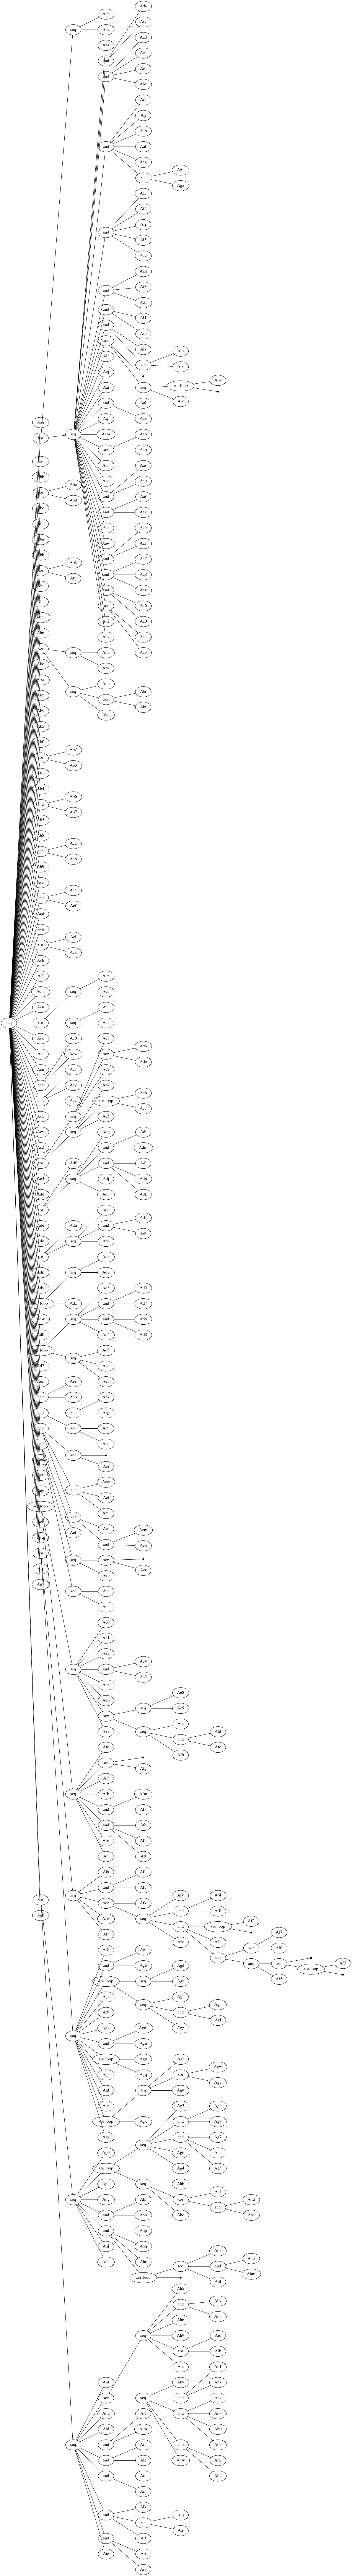

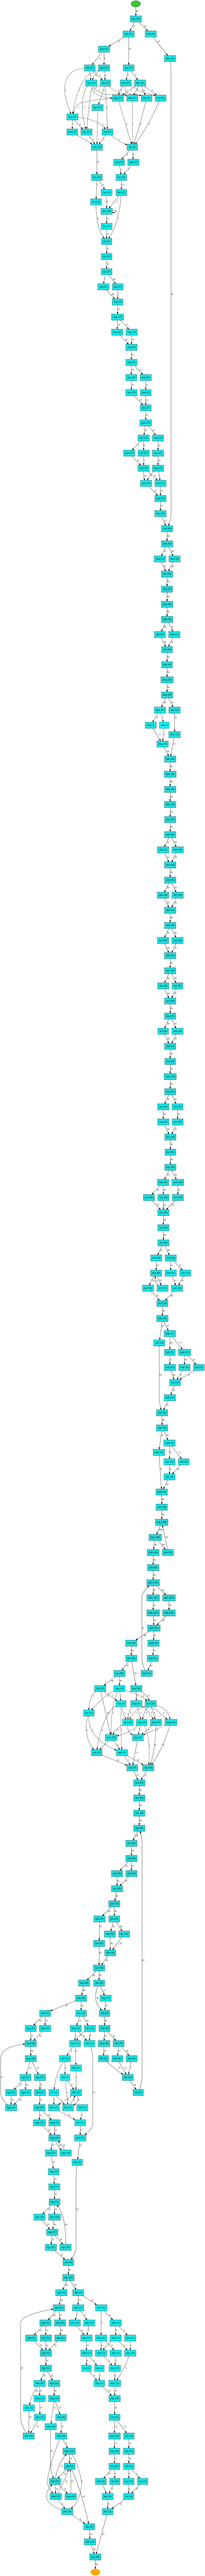

=== Visualization done ===



In [42]:
print("=== Discovering and visualizing process from s_A1 (log_wnoise_2) ===")
# Inductive miner -> process tree
tree_A1 = pm4py.discover_process_tree_inductive(
    s_A1_log, 
    activity_key='activity', 
    case_id_key='case_id', 
    timestamp_key='timestamp'
)
pm4py.view_process_tree(tree_A1)

# Directly-Follows Graph
dfg, starts, ends = pm4py.discover_dfg(
    s_A1_log,
    case_id_key='case_id',
    activity_key='activity',
    timestamp_key='timestamp'
)
pm4py.view_dfg(dfg, starts, ends)

# Heuristics net
heur_net = pm4py.discover_heuristics_net(
    s_A1_log,
    activity_key='activity',
    case_id_key='case_id',
    timestamp_key='timestamp'
)
pm4py.view_heuristics_net(heur_net)

print("=== Visualization done ===\n")


In [34]:
# Syntetic dataset generation
#processes_dict = {'A1': s_A1, 'A2': s_A2}
synth_gen = SyntheticDataGenerator(processes_dict=processes_dict)
synthetic_data = synth_gen.generate(samples_per_dist=1000, mixture_probs_list=[[0.2,]*5])

print("Example of synthetic data:")
for i, sample in enumerate(synthetic_data[:3]):
    print(f"Sample {i+1}: trace length={len(sample['trace'])}, structure={sample['structure']}")
    

Example of synthetic data:
Sample 1: trace length=11376, structure=['A3' 'A3' 'A4' 'A5' 'A1' 'A1' 'A3' 'A1' 'A3' 'A4' 'A4' 'A2' 'A4' 'A3'
 'A3' 'A5' 'A3' 'A3' 'A1' 'A3' 'A3' 'A1' 'A3' 'A1' 'A3' 'A2' 'A2' 'A2'
 'A4' 'A5']
Sample 2: trace length=7953, structure=['A2' 'A2' 'A4' 'A1' 'A2' 'A4' 'A2' 'A4' 'A5' 'A2' 'A4' 'A4' 'A2' 'A4'
 'A1' 'A5' 'A4']
Sample 3: trace length=4218, structure=['A3' 'A5' 'A4' 'A1' 'A1' 'A1' 'A1' 'A3' 'A4' 'A5' 'A2' 'A4' 'A1']


In [39]:
experiments = []
s_r = Counter()
for row in synthetic_data:
    s_r.update(row['structure'])

In [41]:
methods_str = [
    ("Tversky", 'tversky'),
    ("Levenshtein", 'levenshtein'),
#     ("Log Skeleton", 'log_skeleton'),
#     ("Alpha Miner", 'fitness_token_based_replay'),
#     ("Heuristic Miner", 'heuristic')
]

for model_name, sim_method in methods_str:
    print(f"\n=== Testing method: {model_name} ===")
    t0 = time.time()

    PM = {}
    for p in processes_dict:
        PM[p] = ProcessMatcher(processes_dict[p], similarity_method=sim_method, tversky_threshold=0.8)

    s_p = Counter()

    for row in synthetic_data:
        trace_str = row['trace']
        for p in PM:
            pcount = PM[p].count_processes_if_match(trace_str)
            if pcount > 0:
                s_p[p] += pcount


    elapsed = time.time() - t0

    for p in s_p:
        if s_r[p] > 0:
            ratio = s_p[p] / s_r[p]
        else:
            ratio = 0
        print(f"Detected ratio {p}: {ratio:.3f}")

    # experiments.append({
    #     'model': model_name,
    #     'A1(%)': A1_ratio * 100,
    #     'A2(%)': A2_ratio * 100,
    #     'time(sec)': round(elapsed, 2)
    # })

    print(f"time: {elapsed:.2f} s")


=== Testing method: Tversky ===
Detected ratio A1: 0.579
Detected ratio A2: 0.997
Detected ratio A3: 0.995
Detected ratio A4: 0.997
Detected ratio A5: 0.996
time: 41.76 s

=== Testing method: Levenshtein ===
Detected ratio A1: 0.977
Detected ratio A2: 1.000
Detected ratio A3: 1.000
Detected ratio A4: 1.000
Detected ratio A5: 1.000
time: 50.49 s


In [ ]:
methods_pmg = [
#     ("Tversky", 'tversky'),
#     ("Levenshtein", 'levenshtein'),
    ("Log Skeleton", 'log_skeleton'),
    ("Alpha Miner", 'fitness_token_based_replay'),
    ("Heuristic Miner", 'heuristic')
]

for model_name, sim_method in methods_pmg:
    print(f"\n=== Testing method: {model_name} ===")
    t0 = time.time()

    # Use s_A1 and s_A2 (Series of trace strings) instead of s_A1_log.
    pmA1 = ProcessMatcher(s_A1, similarity_method=sim_method, tversky_threshold=0.8)
    pmA2 = ProcessMatcher(s_A2, similarity_method=sim_method, tversky_threshold=0.8)

    s_p = Counter()

    for row in synthetic_data:
        trace_str = row['trace']
        pA1 = pmA1.count_processes_if_match(trace_str)
        pA2 = pmA2.count_processes_if_match(trace_str)
        if pA1 > 0:
            s_p['A1'] += pA1
        if pA2 > 0:
            s_p['A2'] += pA2

    elapsed = time.time() - t0

    if s_r["A1"] > 0:
        A1_ratio = s_p["A1"] / s_r["A1"]
    else:
        A1_ratio = 0

    if s_r["A2"] > 0:
        A2_ratio = s_p["A2"] / s_r["A2"]
    else:
        A2_ratio = 0

    experiments.append({
        'model': model_name,
        'A1(%)': A1_ratio * 100,
        'A2(%)': A2_ratio * 100,
        'time(sec)': round(elapsed, 2)
    })

    print(f"Detected ratio A1: {A1_ratio:.3f}, A2: {A2_ratio:.3f}, time: {elapsed:.2f} s")

In [ ]:
print("\n=== Summary of experiments ===")
df_exp = pd.DataFrame(experiments)
print(df_exp)
print("\nLatex table output:")
print(df_exp.to_latex(index=False))
print("\nDone.")